## 1. Decision Trees as Interpretable Models

Import packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale

### (a) Obtain Data

Get the Accute Inamations Data Set

In [ ]:
#read data
data = pd.read_csv('diagnosis.data', encoding='utf-16', sep='\t', decimal=',',names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Bladder','Pelvis'])

#yes = 1, no = 0
for i in data.columns[1:]:
    data.loc[:, i] =  data.loc[:, i].map(lambda v : 1 if v == 'yes' else 0)
data.head()

<ipython-input-45-97275cd6e795>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, i] =  data.loc[:, i].map(lambda v : 1 if v == 'yes' else 0)


,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Bladder,Pelvis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


### (b) Build a decision tree

[Text(0.4, 0.9, 'x[0] <= 37.95\nentropy = 0.99\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'x[3] <= 0.5\nentropy = 0.459\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'entropy = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.3, 0.5, 'entropy = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.6, 0.7, 'x[2] <= 0.5\nentropy = 0.775\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'entropy = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'x[4] <= 0.5\nentropy = 0.479\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'entropy = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'x[3] <= 0.5\nentropy = 0.465\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'entropy = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'entropy = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

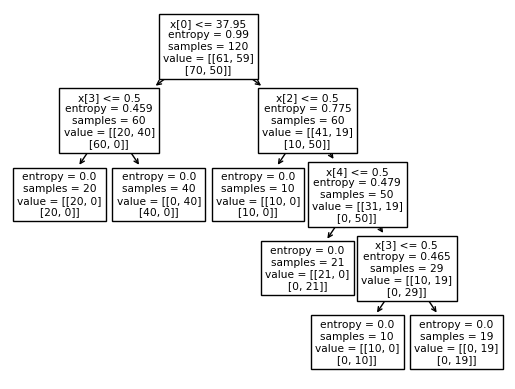

In [ ]:
#features and target variable
X = data.values[:,0:6]
y = data.values[:,6:]

#plot decision tree
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt=dt.fit(X, y)
tree.plot_tree(dt)

### (c) Convert the decision rules

In [ ]:
def tree_to_pseudo(tree, feature_names):
	"""
	Outputs a decision tree model as if/then pseudocode

	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as pseudocode
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	left = tree.tree_.children_left
	right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	features = [feature_names[i] for i in tree.tree_.feature]
	value = tree.tree_.value

	def recurse(left, right, threshold, features, node, depth=0):
		indent = "  " * depth
		if (threshold[node] != -2):
			print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
			if left[node] != -1:
				recurse (left, right, threshold, features, left[node], depth+1)
				print(indent,"} else {")
				if right[node] != -1:
					recurse (left, right, threshold, features, right[node], depth+1)
				print(indent,"}")
		else:
			print(indent,"return " + str(value[node]))

	recurse(left, right, threshold, features, 0)

In [ ]:
names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Bladder','Pelvis']
tree_to_pseudo(dt, names)

 if ( Temperature <= 37.95000076293945 ) {
   if ( Urine <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   if ( Lumbar <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( Micturition <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( Urine <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


In [ ]:
#alpha values
path = dt.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#train decision trees with different alpha values
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

#smallest tree size
clf = clfs[np.argmin([clf.tree_.node_count for clf in clfs])]

#print minimal decision tree
print(clf)

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [ ]:
#read data
with open ('communities.names') as fcommunities:
    a = fcommunities.read()

#find all attributes
features = re.findall(r'(?<=@attribute\s)(\S*)',a)
comminitiesdata = pd.read_csv('communities.data',na_values=['?'],names=features)
comminitiesdata

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [ ]:
df = comminitiesdata.drop(['state','county','community','communityname','fold'], axis=1)

### (b) Missing values

In [ ]:
df = df.fillna(df.mean())

train = df.iloc[0:1495,]
train

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


### (c) Plot a correlation matrix

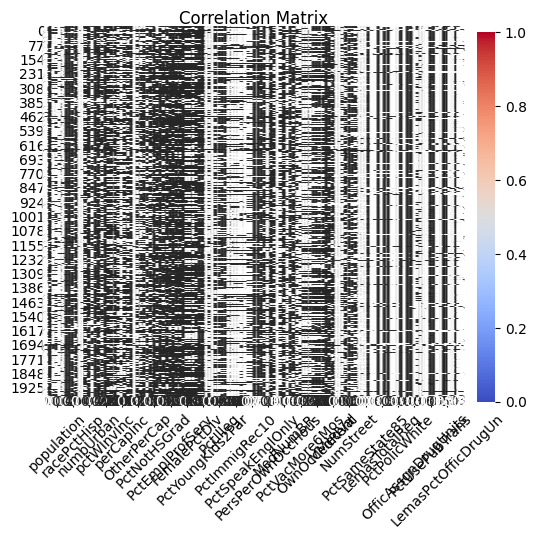

In [ ]:
df_corr = df.drop(['ViolentCrimesPerPop'],axis=1)
#plt.figure(figsize=(200, 80))

sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

### (d) Calculate the Coefficient of Variation CV

In [ ]:
cv=df_corr.std()/df_corr.mean()
cv

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
PolicOperBudg          0.730107
LemasPctPolicOnPatr    0.122331
LemasGangUnitDeploy    0.368040
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.337281
Length: 122, dtype: float64

### (e) Scatter plots and box plots for highest CV features

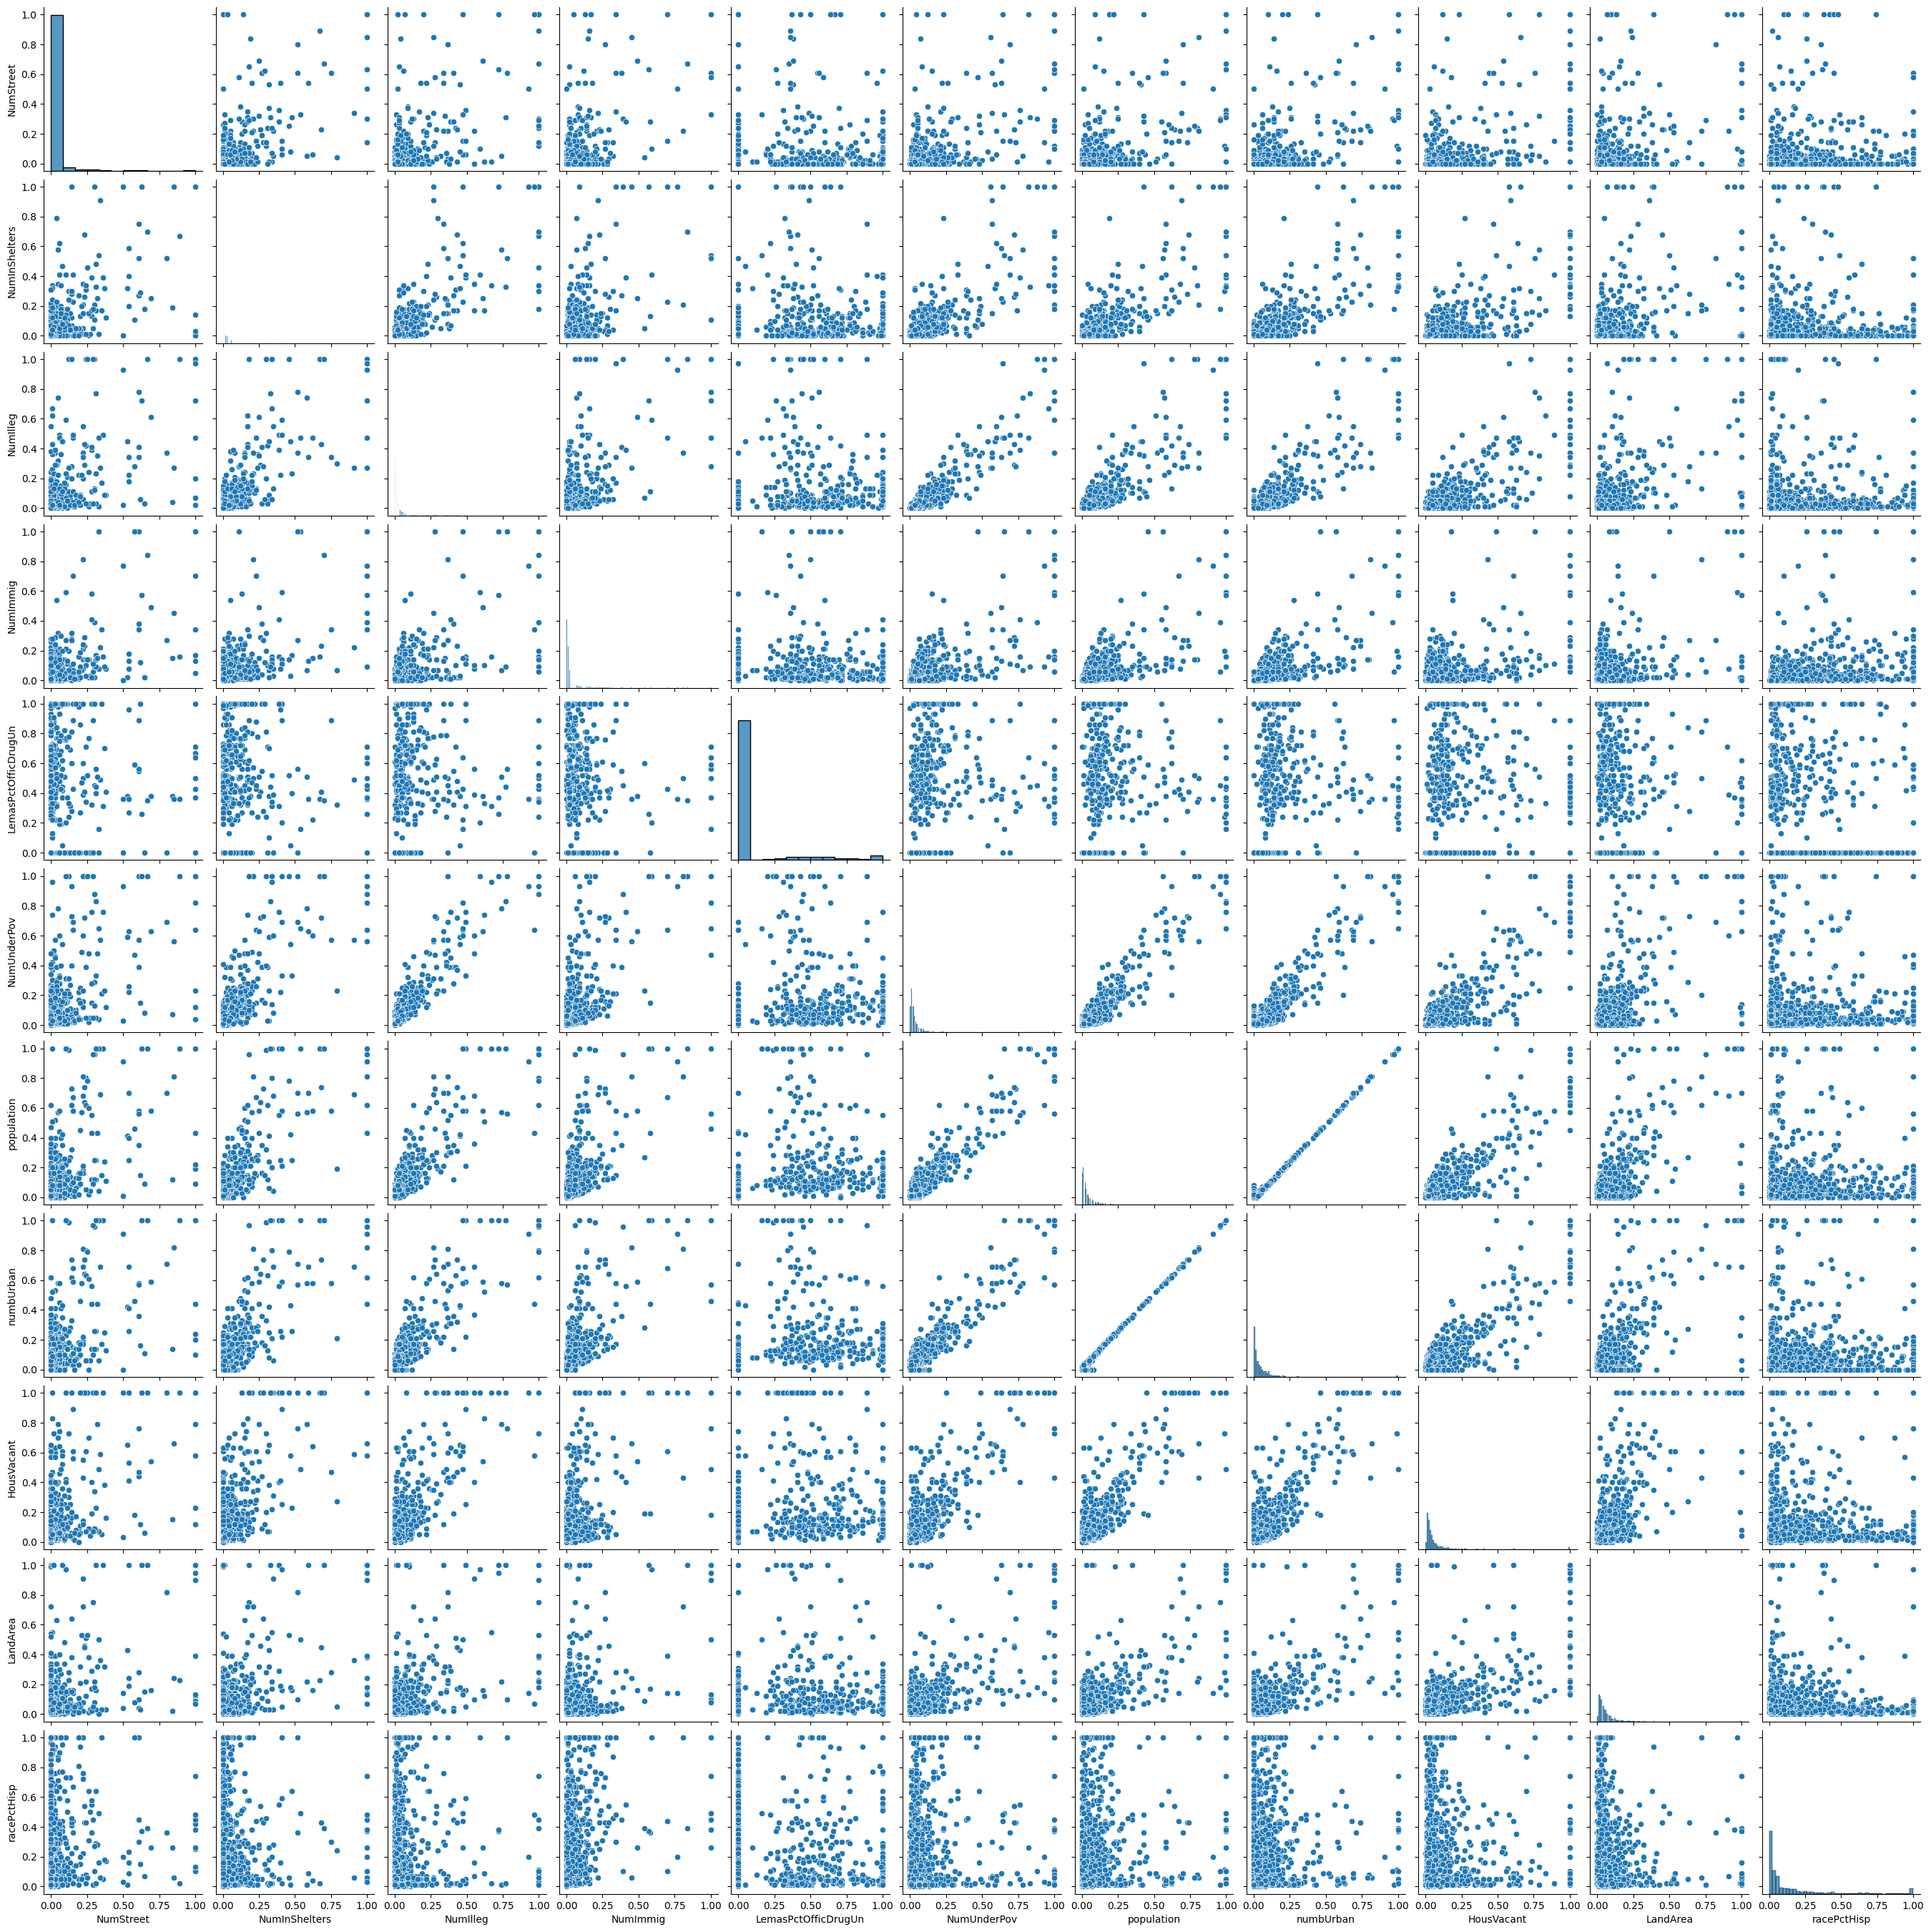

In [ ]:
#choose top (128)^0.5 features
selected_features = cv.nlargest(int(np.sqrt(128))).index
sns.pairplot(data=df[selected_features])
plt.show()

### (f) Fit a linear model

In [ ]:
#split data into train and test sets
train = df.iloc[:1495, :]
test = df.iloc[1495:, :]

#features and values
train_x=train.values[:,:122]
train_y=train.values[:,122]
test_x=test.values[:,:122]
test_y=test.values[:,122]

#linear regression model
reg = LinearRegression().fit(train_x, train_y)

#prediction
pred_test_y = reg.predict(test_x)

#test error
test_error=mean_squared_error(pred_test_y,test_y)
print('Test error:',test_error)

Test error: 0.789725527420882


### (g) Fit a ridge regression model

In [ ]:
alpha_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                10.0]

#initialize and fit model
clf = RidgeCV(alphas=alpha_values)
clf.fit(train_x, train_y)

#predict
pred_test_y1 = clf.predict(test_x)
test_error1=mean_squared_error(pred_test_y1,test_y)

#print test error
print('Ridge regression test error: ',test_error1)

Ridge regression test error:  0.01762517018017133


### (h) Fit a LASSO model

In [ ]:
#initialize model
lassolambda = LassoCV(alphas=alpha_values).fit(train_x, train_y)

#predict target variable
pred_test_y2 = lassolambda.predict(test_x)
test_error2 = mean_squared_error(pred_test_y2,test_y)
print('Lasso regression test error: ',test_error2)

#get selected variables
selected_variables = train.columns[:-1][lassolambda.coef_ != 0]

#print selected variables
print('Selected variables:')
for var in selected_variables:
    print(var)

Lasso regression test error:  0.020919681104181242
Selected variables:
racePctWhite
PctKids2Par
PctIlleg


In [ ]:
scaler = StandardScaler()

#standardize data
train_x_standardized = scaler.fit_transform(train_x)
test_x_standardized = scaler.transform(test_x)

#initialize model
lasso_lambda_standardized = LassoCV(alphas=alpha_values).fit(train_x_standardized, train_y)

#predict target variable
pred_test_y_lasso_standardized = lasso_lambda_standardized.predict(test_x_standardized)

#calculate mse
test_error_lasso_standardized = mean_squared_error(pred_test_y_lasso_standardized, test_y)

#print test error
print('Lasso regression test error (standardized features):', test_error_lasso_standardized)

#get selected variables

selected_variables_lasso_standardized = train.columns[:-1][lasso_lambda_standardized.coef_ != 0]

#print selected variables
print("Selected variables (standardized features):")
for var in selected_variables_lasso_standardized:
    print(var)

Lasso regression test error (standardized features): 0.01734465469734718
Selected variables (standardized features):
racepctblack
racePctWhite
pctUrban
MalePctDivorce
PctKids2Par
PctWorkMom
PctIlleg
PctPersDenseHous
HousVacant
PctHousOccup
PctVacantBoarded
MedRentPctHousInc
NumStreet
PctForeignBorn


The test error for the standardized features is slightly smaller. This may be due to more stability in the model and scaling that mitigates the influence of variables with large scales.

### (i) Fit a PCR model

In [ ]:
#initialize
pca = PCA()

#fit and transform
X_reduced = pca.fit_transform(scale(train_x))

#cv methods
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#initialize linear regression model
regr = LinearRegression()

#calc mse w intercept
mse = [-cross_val_score(regr, np.ones((len(X_reduced), 1)), train_y, cv=cv, scoring='neg_mean_squared_error').mean()]

#calc mse adding one component at a time
for i in range(1, len(train_x[0])):
    mse.append(-cross_val_score(regr, X_reduced[:, :i], train_y, cv=cv, scoring='neg_mean_squared_error').mean())

print("MSE:", mse)

MSE: [0.0565200043827612, 0.033123988572677204, 0.029378042832721427, 0.028328044022776815, 0.02839719461394797, 0.026171302148055707, 0.026222827290532155, 0.025823794952435402, 0.021947009969251037, 0.021093345829353325, 0.021012831300797126, 0.021028120531643334, 0.021070710684004342, 0.020831743213700238, 0.020844184259942687, 0.020806005353163685, 0.020757654539750738, 0.02066303954388897, 0.02043778246223514, 0.02044875062335022, 0.020475947603603394, 0.020492500336689257, 0.02042002708439657, 0.020452536688076204, 0.02047182233716379, 0.020494181743188195, 0.020511256596143404, 0.02029584717889108, 0.0202303071262614, 0.020237456869298263, 0.020148834653147242, 0.019989581011930414, 0.02004144142678608, 0.0200243712574022, 0.02004242086818538, 0.020060584793875496, 0.020029726021228225, 0.02003014751521552, 0.020061241293525416, 0.020080231835023197, 0.020109388870960643, 0.020129860253225194, 0.020074373589786917, 0.020062629562010513, 0.019957214364438963, 0.019968124712431114

In [ ]:
print('Minimum mse %f occurs when there are %d components'%(min(mse),mse.index(min(mse))))

Minimum mse 0.019543 occurs when there are 95 components


### (j) Fit a boosting tree

In [ ]:
param_grid = {'alpha': alpha_values}

#initialize model
xgb = XGBRegressor(tree_method='hist')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_x, train_y)

#get best alpha
a = grid_search.best_params_['alpha']

#xgb boost with best alpha
xgb_model = XGBRegressor(alpha=a, tree_method='hist')
xgb_model.fit(train_x, train_y)

#predict on test data
pred_test_y_xgb = xgb_model.predict(test_x)

#calculate and print mse
test_error_xgb = mean_squared_error(pred_test_y_xgb, test_y)
print('XGBoost regression test error:', test_error_xgb)

XGBoost regression test error: 0.017584000280926965
